In [1]:
from base import *
from distance import *
from greedy import *
from ioUtils import *
from scipy import io
import matplotlib.pyplot as plt
rmin, rmax = 0.5, 2
c1, c2, c3 = 2, 3, 1

In [143]:
# # 将 np.array 转换为字典
# def convertArrayToDict(data):
#     trajs = {}
#     for trID in range(data.shape[0]):
#         trajectary = traj()
#         timestamp = 0
#         for point in data[trID]:
#             lat, lon = point
#             trajectary.addPt(lat, lon, trID, timestamp)
#             timestamp += 1
#         trajs[trID] = trajectary
#     return trajs


# data_mat = io.loadmat('data/TRAFFIC_trans.mat')
# data_ori = data_mat['data']
# data_subset = data_ori[0:150]
# data_Dict = convertArrayToDict(data_ori)
# writeTrajsToTxtFile('TRAFFIC_subset2.txt', data_Dict)

In [215]:
print("Loading trajectories ...")
trajs = readTrajsFromTxtFile("data/TRAFFIC.txt")

rmin, rmax = 0.5, 2  

print("Computing Frechet distances ...")
distPairs1 = process(trajs, rmin, rmax)




Loading trajectories ...
Computing Frechet distances ...


In [324]:
# distPairs1 is of form {(pth, straj):dist}, change it to distPairs2 of the form {(pth, trajID):[(straj, dist)]}
distPairs2 = {}
for k, v in distPairs1.items():
    pth, trID, dist, straj = k[0], k[1].trajID, v, k[1]
    if (pth, trID) in distPairs2:
        distPairs2[(pth, trID)].append((straj, dist))
    else:
        distPairs2[(pth, trID)] = [(straj, dist)]

print("Computing prerequisite data structures ...")
(strajCov, ptStraj, strajPth, trajCov) = preprocessGreedy(trajs, distPairs2)

c1, c2, c3 = 2, 3, 1
print("Running greedy algorithm ...")
retVal = runGreedy(trajs, distPairs2, strajCov, ptStraj, strajPth, trajCov, c1, c2, c3)

Computing prerequisite data structures ...
Running greedy algorithm ...
num of points is 15000
Key (<base.pathlet object at 0x0000021627121208>, 193) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 173) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 198) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 173) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 198) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 173) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 198) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 173) not found in distPairs
Key (<base.pathlet object at 0x000002162719E438>, 198) not found in distPairs
Key (<base.pathlet object at 0x0000021627190630>, 173) not found in distPairs
Key (<base.pathlet object at 0x0000021627190630>, 198) not found in distPairs
Key (<base.pathlet object at 0x0000021627190630

In [368]:
def pathlet_dict_to_array(pathlet_dict):
    """
    clusters = [cluster1, cluster2, cluster3, ...],
    cluster=[subtrajectory1, subtrajectory2, ...],
    subtrajectory = [point1, point2, ...],
    point=[lat, lng]
    """

    clusters = []
    pathlets = []

    for pathlet, subtrajs in pathlet_dict.items():

        pth = []
        trajID = pathlet.trajID
        start, end = pathlet.bounds
        apts = trajs[trajID].pts[start : end + 1]
        for point in apts:
            pth.append([point.lon, point.lat])
        pathlets.append(np.array(pth))

        cluster = []

        for subtraj in subtrajs:
            subtrajectory = []

            trajID = subtraj.trajID
            start, end = subtraj.bounds

            pts = trajs[trajID].pts[start : end + 1]
            for point in pts:
                subtrajectory.append([point.lon, point.lat])

            cluster.append(np.array(subtrajectory))
        clusters.append(np.array(cluster))
    return pathlets, clusters

def save_result(fname, pathlets, clusters):
    path = './result/'+fname
    io.savemat(path, {'pathlets' : pathlets, 'clusters':clusters})

In [369]:
retVal[0].__len__()

176

In [370]:
pathlets, clusters = pathlet_dict_to_array(retVal[0])

d:\Program Files\Anaconda\envs\traclus\lib\site-packages\ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [371]:
# res_pth = []
# res_subtra = []
# for pthlt, subt in retVal[0].items():
#     res_pth.append([pthlt])
#     res_subtra.append(subt)

In [372]:
def objToLine(obj):
    lines = []
    for l in obj:
        line = []
        trajID = l.trajID
        start, end = l.bounds
        apts = trajs[trajID].pts[start : end + 1]
        for point in apts:
            line.append([point.lon, point.lat])
        lines.append(line)
    return lines

In [373]:
save_result(f"result_rmin{rmin}_rmax{rmax}_c{c1}_{c2}_{c3}.mat", pathlets = pathlets, clusters=clusters)

d:\Program Files\Anaconda\envs\traclus\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [2]:
data_mat = io.loadmat(f"./result/result_rmin{rmin}_rmax{rmax}_c{c1}_{c2}_{c3}.mat")
# data_mat = io.loadmat(f"./result/result_rmin0.5_rmax2_c1_1_1.mat")

pathlets_data = data_mat['pathlets']
clusters_data = data_mat['clusters']

In [11]:
def show_trajectory(trajectory, color=None, marker=None):
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=color, marker=marker)


def show_trajectories(trajectories, color=None, marker=None):
    for trajectory in trajectories:
        show_trajectory(trajectory, color=color, marker=marker)


def show_clusters(clusters, endpoint, color=None, marker=None):
    i = 0
    for cluster in clusters:
        i += 1
        if i > endpoint : return
        if len(cluster.shape) == 2:
            show_trajectories(cluster[0], color=color, marker=marker)
        else:
            show_trajectories(cluster, color=color, marker=marker)

In [377]:
def plot_all_trajectories(trajs, color = None):
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    for trajID, traj in trajs.items():
        x_coords = [point.lon for point in traj.pts]
        y_coords = [point.lat for point in traj.pts]
        plt.plot(x_coords, y_coords, color)

    # plt.xlabel("Longitude")
    # plt.ylabel("Latitude")
    # plt.title("All Trajectories")
    # plt.legend()
    # plt.show()

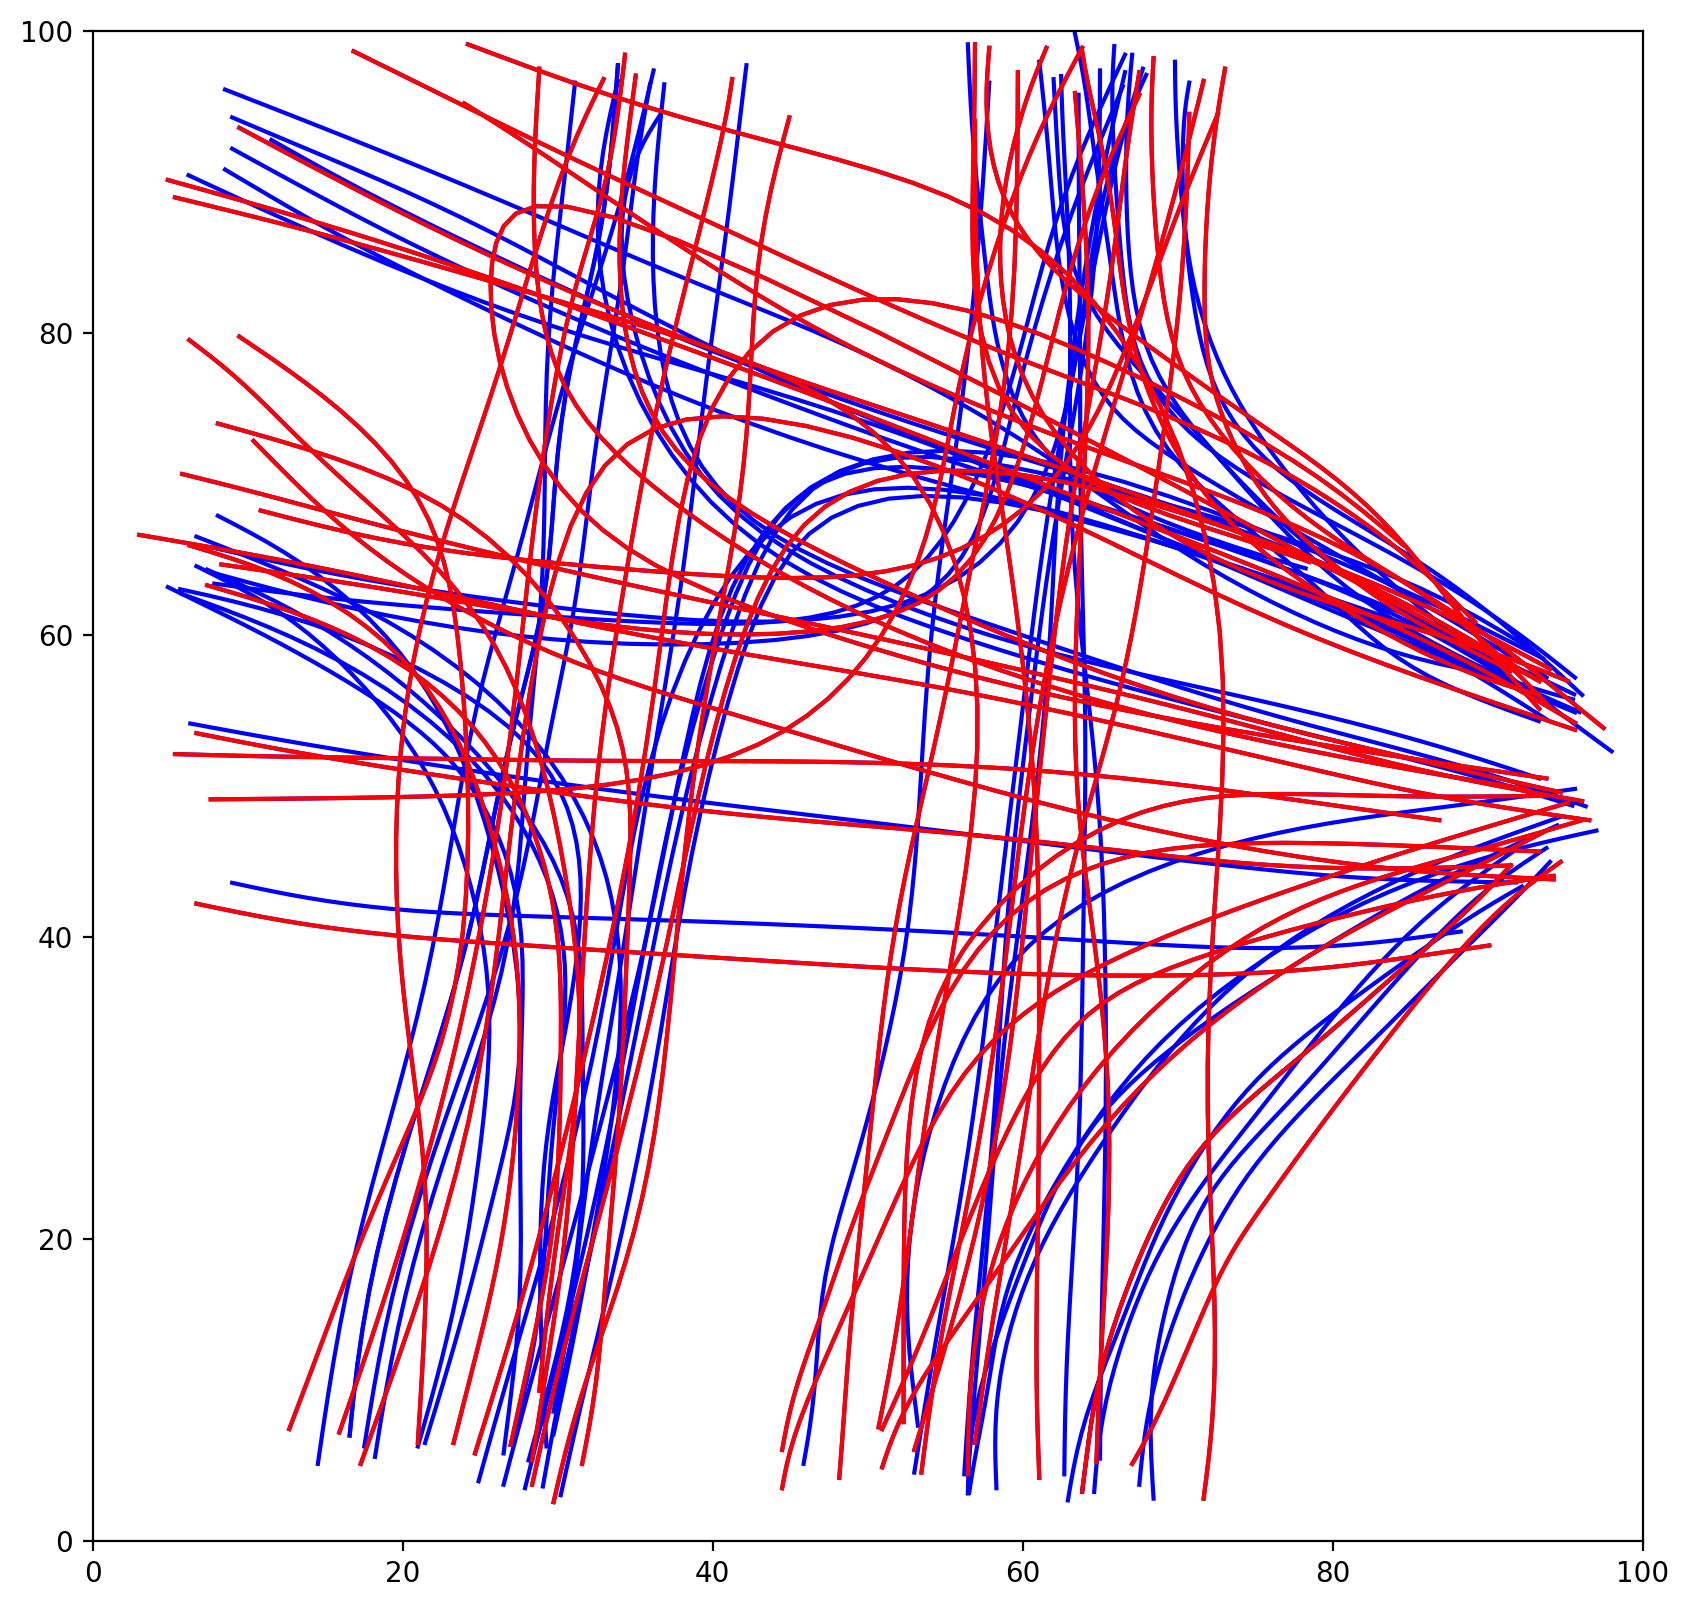

In [19]:
plt.figure(figsize=(10, 10), dpi=200)
plt.xlim(0, 100)
plt.ylim(0, 100)

endpoint = 50
show_clusters(clusters_data[0], endpoint=endpoint, color="blue")

# plot_all_trajectories(trajs, color='green')
for index in range(endpoint):
    show_trajectory(pathlets_data[0][index], color="red")
    # print(pathlets_data[0][index].shape, index)
    # print(clusters_data[0][index].shape, index)

plt.show()